In [1]:
# Install required packages
!pip install openai python-docx PyPDF2 pdfminer.six python-dotenv tqdm matplotlib pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 22.5 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import os
import re
import json
import tempfile
import logging
import traceback
import time
from typing import List, Dict, Any, Tuple
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# For document processing
import PyPDF2
import docx
from pdfminer.high_level import extract_text as pdfminer_extract_text

# For OpenAI API
import openai
from getpass import getpass

# For Colab file handling
from google.colab import files
from google.colab import drive

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Get API key securely
if not os.environ.get("OPENAI_API_KEY"):
    OPENAI_API_KEY = getpass("Enter your OpenAI API key: ")
    os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
else:
    OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

# Set up OpenAI client
openai.api_key = OPENAI_API_KEY

print("Setup complete!")

Enter your OpenAI API key: ··········
Setup complete!


In [3]:
# Configuration
MODEL_NAME = "gpt-4"  # Can be changed to "gpt-3.5-turbo" if needed
MAX_TOKENS = 4096
TEMPERATURE = 0.2
TOP_P = 1.0
BATCH_SIZE = 5  # Number of CVs to process in each batch

# Evaluation Weights
WEIGHTS = {
    "skills": 0.4,
    "experience": 0.4,
    "education": 0.2
}

# File Settings
MAX_FILE_SIZE = 5  # in MB
ALLOWED_EXTENSIONS = ["pdf", "docx", "txt"]

# Define default job description
DEFAULT_JOB_DESCRIPTION = """Job Title: Data Engineer
Responsibilities:
- Design, develop, and maintain scalable data pipelines.
- Collaborate with data scientists, analysts, and business teams to understand data needs.
- Implement ETL processes to extract, transform, and load data from various sources.
- Ensure data quality, consistency, and security.
- Optimize database performance and troubleshoot issues.
Required Skills:
- Proficiency in SQL, Python, and data pipeline tools.
- Experience with cloud platforms such as AWS, Azure, or GCP.
- Strong understanding of data modeling and database design.
- Experience with big data technologies (Hadoop, Spark) is a plus.
- Strong problem-solving and communication skills.
Qualifications:
- Bachelor's degree in Computer Science, Information Technology, or related field.
- Relevant certifications (AWS Data Analytics, Google Cloud Data Engineer) preferred.
"""

# Define system prompt
SYSTEM_PROMPT = """
You are an expert HR recruiter with deep experience in CV evaluation. Your task is to evaluate CVs against job descriptions and provide detailed scoring on skills, experience, and education match. Be objective and thorough in your assessment.

Follow these guidelines:
1. Analyze the CV against the job description systematically
2. Provide numerical scores for each category (skills, experience, education)
3. Justify each score with specific evidence from the CV
4. Identify both strengths and gaps for each category
5. Provide your assessment in the exact JSON format requested
"""

# Define evaluation prompt template
EVALUATION_PROMPT_TEMPLATE = """
# Job Description
{job_description}

# CV to Evaluate
{cv_text}

# Evaluation Criteria
Evaluate this CV against the job description using these criteria:
1. Skills Match (0-10): How well do the candidate's skills align with job requirements?
2. Experience Match (0-10): How relevant is the candidate's work experience?
3. Education Match (0-10): How suitable is the candidate's educational background?
4. Overall Fit (0-10): Overall assessment of candidate suitability

# IMPORTANT: Response Format
Provide your evaluation as valid JSON, strictly following this format:
```json
{
  "skills": {
    "score": 0,
    "reasoning": "detailed explanation",
    "strengths": ["strength1", "strength2"],
    "gaps": ["gap1", "gap2"]
  },
  "experience": {
    "score": 0,
    "reasoning": "detailed explanation",
    "strengths": ["strength1", "strength2"],
    "gaps": ["gap1", "gap2"]
  },
  "education": {
    "score": 0,
    "reasoning": "detailed explanation",
    "strengths": ["strength1", "strength2"],
    "gaps": ["gap1", "gap2"]
  },
  "overall": {
    "score": 0,
    "reasoning": "detailed explanation"
  }
}
Return ONLY the JSON. Do not include any additional text or explanations outside of the JSON structure.
"""
print("Configuration loaded!")


Configuration loaded!


In [4]:
## Cell 4: Colab File Handling Functions

# Colab file upload functions
def upload_files_colab():
    """Upload files through Google Colab's interface"""
    uploaded = files.upload()
    file_paths = {}

    for filename, content in uploaded.items():
        # Save the content to a temporary file
        with open(filename, 'wb') as f:
            f.write(content)
        file_paths[filename] = filename
        print(f"Saved uploaded file: {filename}")

    return file_paths

def mount_google_drive():
    """Mount Google Drive to access files"""
    drive.mount('/content/drive')
    print("Google Drive mounted at /content/drive")
    return '/content/drive/My Drive'

def get_cv_files_from_directory(directory_path):
    """Get all CV files from a directory"""
    cv_files = []

    if not os.path.exists(directory_path):
        print(f"Directory does not exist: {directory_path}")
        return cv_files

    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        if os.path.isfile(file_path):
            file_ext = os.path.splitext(filename)[1].lower().replace('.', '')
            if file_ext in ALLOWED_EXTENSIONS:
                cv_files.append(file_path)

    return cv_files

print("File handling functions loaded!")

File handling functions loaded!


In [5]:
class CVProcessor:
    """Handles extraction and preprocessing of CV text from different file formats"""

    def __init__(self):
        self.logger = logging.getLogger(__name__)

    def extract_text_from_pdf(self, file_path: str) -> str:
        """Extract text from a PDF file using multiple methods for robustness"""
        text = ""
        error_messages = []

        # Try PyPDF2 first
        try:
            with open(file_path, 'rb') as file:
                reader = PyPDF2.PdfReader(file)
                for page in reader.pages:
                    text += page.extract_text() + "\n"

            # If we got reasonable text, return it
            if len(text.strip()) > 100:  # Arbitrary threshold to check if we got meaningful text
                return text
        except Exception as e:
            error_messages.append(f"PyPDF2 extraction failed: {str(e)}")

        # If PyPDF2 fails or returns too little text, try pdfminer
        try:
            text = pdfminer_extract_text(file_path)
            if len(text.strip()) > 0:
                return text
        except Exception as e:
            error_messages.append(f"pdfminer extraction failed: {str(e)}")

        # Log all errors if both methods failed
        if not text:
            for msg in error_messages:
                self.logger.error(msg)
            raise Exception(f"Failed to extract text from PDF using multiple methods: {', '.join(error_messages)}")

        return text

    def extract_text_from_docx(self, file_path: str) -> str:
        """Extract text from a DOCX file"""
        try:
            doc = docx.Document(file_path)
            full_text = []

            # Extract text from paragraphs
            for para in doc.paragraphs:
                full_text.append(para.text)

            # Extract text from tables
            for table in doc.tables:
                for row in table.rows:
                    for cell in row.cells:
                        full_text.append(cell.text)

            return '\n'.join(full_text)
        except Exception as e:
            self.logger.error(f"Error extracting text from DOCX {file_path}: {str(e)}")
            raise Exception(f"Failed to extract text from DOCX: {str(e)}")

    def extract_text_from_txt(self, file_path: str) -> str:
        """Extract text from a TXT file"""
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                return file.read()
        except UnicodeDecodeError:
            # Try with a different encoding if utf-8 fails
            try:
                with open(file_path, 'r', encoding='latin-1') as file:
                    return file.read()
            except Exception as e:
                self.logger.error(f"Error extracting text from TXT {file_path} with latin-1 encoding: {str(e)}")
                raise
        except Exception as e:
            self.logger.error(f"Error extracting text from TXT {file_path}: {str(e)}")
            raise Exception(f"Failed to extract text from TXT: {str(e)}")

    def extract_text(self, file_path: str) -> str:
        """Extract text from a file based on its extension"""
        _, ext = os.path.splitext(file_path)
        ext = ext.lower()

        if ext == '.pdf':
            return self.extract_text_from_pdf(file_path)
        elif ext == '.docx':
            return self.extract_text_from_docx(file_path)
        elif ext == '.txt':
            return self.extract_text_from_txt(file_path)
        else:
            error_msg = f"Unsupported file format: {ext}"
            self.logger.error(error_msg)
            raise ValueError(error_msg)

    def preprocess_cv_text(self, text: str) -> str:
        """Clean and preprocess CV text"""
        if not text or len(text.strip()) == 0:
            raise ValueError("Extracted text is empty after preprocessing")

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)

        # Remove any non-printable characters
        text = ''.join(c for c in text if c.isprintable() or c.isspace())

        # Remove multiple newlines
        text = re.sub(r'\n\s*\n', '\n\n', text)

        return text

    def extract_sections(self, text: str) -> Dict[str, str]:
        """
        Extract common sections from a CV
        This is a more robust implementation to better handle different CV formats
        """
        # Define section markers - patterns commonly found in CVs
        section_patterns = {
            "skills": [
                r'\b(?:technical\s+)?skills\b',
                r'\bcompetenc(?:y|ies)\b',
                r'\bproficienc(?:y|ies)\b',
                r'\bqualifications\b',
                r'\bcore\s+abilities\b',
                r'\bkey\s+skills\b',
                r'\bareas\s+of\s+expertise\b'
            ],
            "experience": [
                r'\bwork\s+experience\b',
                r'\bemployment\s+(?:history|record)\b',
                r'\bprofessional\s+experience\b',
                r'\bcareer\s+history\b',
                r'\bjob\s+history\b',
                r'\bwork\s+history\b',
                r'\bexperience\b'
            ],
            "education": [
                r'\beducation(?:al)?\s+(?:background|history|qualifications)?\b',
                r'\bacademic\s+(?:background|history|qualifications|record)\b',
                r'\bqualifications\b',
                r'\bdegrees?\b',
                r'\beducation\b'
            ]
        }

        # Initial section dictionary
        sections = {
            "skills": "",
            "experience": "",
            "education": "",
            "other": ""
        }

        # Split text into lines for processing
        lines = text.split('\n')
        current_section = "other"
        section_text = {k: [] for k in sections.keys()}

        # Process each line
        for i, line in enumerate(lines):
            line = line.strip()
            if not line:  # Skip empty lines
                continue

            # Check if this line is a section header
            new_section_found = False
            for section, patterns in section_patterns.items():
                for pattern in patterns:
                    if re.search(pattern, line.lower()):
                        current_section = section
                        new_section_found = True
                        break
                if new_section_found:
                    break

            # If not a section header, add to current section
            if not new_section_found:
                section_text[current_section].append(line)

        # Join the section text
        for section in sections:
            sections[section] = '\n'.join(section_text[section])

        # If any main section is empty, try to assign content from "other"
        if sections["other"] and (not sections["skills"] or not sections["experience"] or not sections["education"]):
            other_text = sections["other"]

            # Try to extract skills
            if not sections["skills"]:
                skills_extracted = self._extract_skills_from_text(other_text)
                if skills_extracted:
                    sections["skills"] = skills_extracted

            # Try to extract education (simpler approach than skills)
            if not sections["education"]:
                education_keywords = ['degree', 'university', 'college', 'school', 'bachelor', 'master', 'phd', 'diploma']
                education_lines = []
                for line in other_text.split('\n'):
                    if any(keyword in line.lower() for keyword in education_keywords):
                        education_lines.append(line)
                if education_lines:
                    sections["education"] = '\n'.join(education_lines)

        return sections

    def _extract_skills_from_text(self, text: str) -> str:
        """Extract skills from text using common skill-related keywords"""
        skill_keywords = [
            'python', 'java', 'javascript', 'sql', 'html', 'css', 'react', 'angular', 'vue',
            'node', 'express', 'django', 'flask', 'spring', 'hibernate', 'jquery', 'bootstrap',
            'sass', 'less', 'webpack', 'babel', 'git', 'github', 'gitlab', 'bitbucket', 'svn',
            'aws', 'azure', 'gcp', 'docker', 'kubernetes', 'jenkins', 'circleci', 'travis',
            'agile', 'scrum', 'kanban', 'jira', 'confluence', 'trello', 'slack', 'teams',
            'linux', 'unix', 'windows', 'macos', 'android', 'ios', 'swift', 'kotlin', 'objective-c',
            'c', 'c++', 'c#', '.net', 'asp.net', 'ruby', 'rails', 'php', 'laravel', 'symfony',
            'wordpress', 'drupal', 'joomla', 'magento', 'shopify', 'woocommerce', 'prestashop',
            'seo', 'sem', 'smm', 'google ads', 'facebook ads', 'instagram ads', 'twitter ads',
            'adobe', 'photoshop', 'illustrator', 'indesign', 'xd', 'figma', 'sketch', 'invision',
            'excel', 'word', 'powerpoint', 'access', 'outlook', 'onedrive', 'sharepoint',
            'mongodb', 'mysql', 'postgresql', 'oracle', 'sql server', 'sqlite', 'redis', 'elasticsearch',
            'communication', 'teamwork', 'leadership', 'problem solving', 'critical thinking',
            'time management', 'organization', 'adaptability', 'flexibility', 'creativity',
            'analytical', 'detail-oriented', 'multitasking', 'decision making', 'negotiation',
            'presentation', 'public speaking', 'writing', 'editing', 'proofreading', 'research'
        ]

        skill_lines = []
        for line in text.split('\n'):
            line_lower = line.lower()
            if any(keyword in line_lower for keyword in skill_keywords):
                skill_lines.append(line)

        return '\n'.join(skill_lines) if skill_lines else ""

    def process_cv(self, file_path: str) -> Dict[str, Any]:
        """Process a single CV file"""
        try:
            self.logger.info(f"Processing CV: {file_path}")

            # Check if file exists
            if not os.path.exists(file_path):
                error_msg = f"File does not exist: {file_path}"
                self.logger.error(error_msg)
                return {"error": error_msg, "filename": os.path.basename(file_path)}

            # Extract text
            text = self.extract_text(file_path)

            if not text or len(text.strip()) == 0:
                error_msg = f"No text could be extracted from {file_path}"
                self.logger.error(error_msg)
                return {"error": error_msg, "filename": os.path.basename(file_path)}

            # Preprocess text
            processed_text = self.preprocess_cv_text(text)

            # Extract sections
            sections = self.extract_sections(processed_text)

            # Log success
            self.logger.info(f"Successfully processed CV: {file_path}")

            return {
                "filename": os.path.basename(file_path),
                "full_text": processed_text,
                "sections": sections
            }
        except Exception as e:
            error_msg = f"Error processing CV {file_path}: {str(e)}"
            self.logger.error(error_msg)
            self.logger.error(traceback.format_exc())
            return {"error": error_msg, "filename": os.path.basename(file_path)}

print("CV Processor class loaded!")

CV Processor class loaded!


In [6]:
class OpenAIClient:
    """Wrapper for OpenAI API interactions"""

    def __init__(self, api_key: str = None, model: str = None):
        self.api_key = api_key or OPENAI_API_KEY
        self.model = model or MODEL_NAME
        self.logger = logging.getLogger(__name__)

        # Set up OpenAI client
        openai.api_key = self.api_key

    def generate_evaluation(self, system_prompt: str, user_prompt: str, temperature: float = TEMPERATURE) -> Dict[str, Any]:
        """
        Generate an evaluation using OpenAI's API
        Returns the model's response
        """
        try:
            self.logger.info(f"Sending request to OpenAI API (model: {self.model})")

            response = openai.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=temperature,
                max_tokens=MAX_TOKENS,
                top_p=TOP_P
            )

            content = response.choices[0].message.content
            self.logger.info("Received response from OpenAI API")

            return {
                "content": content,
                "usage": response.usage.to_dict() if hasattr(response, 'usage') else None
            }

        except Exception as e:
            self.logger.error(f"Error generating evaluation: {str(e)}")
            self.logger.error(traceback.format_exc())
            return {"error": str(e)}

    def process_with_retry(self, system_prompt: str, user_prompt: str, max_retries: int = 3,
                          backoff_factor: float = 2.0) -> Dict[str, Any]:
        """
        Process a prompt with retry logic for API failures
        """
        retry = 0
        while retry < max_retries:
            try:
                return self.generate_evaluation(system_prompt, user_prompt)
            except Exception as e:
                retry += 1
                if retry >= max_retries:
                    self.logger.error(f"Failed after {max_retries} retries: {str(e)}")
                    return {"error": str(e)}

                # Exponential backoff
                sleep_time = backoff_factor ** retry
                self.logger.warning(f"Retry {retry}/{max_retries} after {sleep_time}s: {str(e)}")
                time.sleep(sleep_time)

    def parse_json_response(self, response: Dict[str, Any]) -> Dict[str, Any]:
        """
        Parse JSON from the model's response
        Handles cases where the model might not return proper JSON
        """
        if "error" in response:
            return {"error": response["error"]}

        content = response.get("content", "")
        if not content:
            return {"error": "Empty response from model"}

        try:
            # First, try to extract JSON using regex for more flexibility
            json_pattern = r'({[\s\S]*})'
            matches = re.findall(json_pattern, content)

            if matches:
                # Try each potential JSON match
                for match in matches:
                    try:
                        result = json.loads(match)
                        # Check if it has the expected structure
                        if "skills" in result and "experience" in result and "education" in result:
                            return result
                    except:
                        continue

            # If regex didn't work, try standard extraction methods
            if "```json" in content:
                json_str = content.split("```json")[1].split("```")[0].strip()
                result = json.loads(json_str)
                return result
            elif "```" in content:
                # Try to find any code block
                code_blocks = re.findall(r'```(?:\w*\n)?([\s\S]*?)```', content)
                if code_blocks:
                    for block in code_blocks:
                        try:
                            result = json.loads(block.strip())
                            return result
                        except:
                            continue

            # Last resort - try the whole content
            try:
                return json.loads(content)
            except:
                # Try to find and extract JSON-like structures
                try:
                    # Find the opening and closing braces
                    start_idx = content.find('{')
                    end_idx = content.rfind('}')

                    if start_idx != -1 and end_idx != -1 and end_idx > start_idx:
                        json_str = content[start_idx:end_idx+1]
                        return json.loads(json_str)
                except:
                    pass

            # If we get here, we couldn't parse JSON
            self.logger.error(f"Failed to extract valid JSON from response")
            return {
                "error": f"Could not parse JSON from response. Raw response: {content[:500]}...",
                "skills": {"score": 0, "reasoning": "Error parsing response", "strengths": [], "gaps": []},
                "experience": {"score": 0, "reasoning": "Error parsing response", "strengths": [], "gaps": []},
                "education": {"score": 0, "reasoning": "Error parsing response", "strengths": [], "gaps": []},
                "overall": {"score": 0, "reasoning": "Error parsing response"}
            }

        except Exception as e:
            self.logger.error(f"Error during JSON parsing: {str(e)}")
            self.logger.error(traceback.format_exc())

            # Return a fallback structure so the app doesn't crash
            return {
                "error": f"JSON parsing error: {str(e)}",
                "skills": {"score": 0, "reasoning": f"Error: {str(e)}", "strengths": [], "gaps": []},
                "experience": {"score": 0, "reasoning": f"Error: {str(e)}", "strengths": [], "gaps": []},
                "education": {"score": 0, "reasoning": f"Error: {str(e)}", "strengths": [], "gaps": []},
                "overall": {"score": 0, "reasoning": f"Error: {str(e)}"}
            }

print("OpenAI Client class loaded!")

OpenAI Client class loaded!


In [7]:
class RankingEngine:
    """Core ranking logic for CV evaluation"""

    def __init__(self):
        self.openai_client = OpenAIClient()
        self.logger = logging.getLogger(__name__)
        self.weights = WEIGHTS

    def format_prompt(self, job_description: str, cv_data: Dict[str, Any]) -> str:
        """Format the evaluation prompt with job description and CV text"""
        return EVALUATION_PROMPT_TEMPLATE.replace("{job_description}", job_description).replace("{cv_text}", cv_data.get("full_text", ""))

    def calculate_weighted_score(self, evaluation: Dict[str, Any]) -> float:
        """Calculate weighted score based on evaluation results"""
        try:
            skills_score = evaluation.get("skills", {}).get("score", 0) * self.weights["skills"]
            experience_score = evaluation.get("experience", {}).get("score", 0) * self.weights["experience"]
            education_score = evaluation.get("education", {}).get("score", 0) * self.weights["education"]

            return skills_score + experience_score + education_score
        except Exception as e:
            self.logger.error(f"Error calculating weighted score: {str(e)}")
            return 0.0

    def evaluate_cv(self, job_description: str, cv_data: Dict[str, Any]) -> Dict[str, Any]:
        """Evaluate a single CV against a job description"""
        filename = cv_data.get("filename", "Unknown")
        self.logger.info(f"Starting evaluation of CV: {filename}")

        try:
            # Skip if there was an error processing the CV
            if "error" in cv_data:
                error_msg = f"Skipping evaluation due to CV processing error: {cv_data['error']}"
                self.logger.warning(error_msg)
                return {
                    "filename": filename,
                    "error": cv_data["error"],
                    "score": 0,
                    "evaluation": None
                }

            # Validate that we have necessary data
            if "full_text" not in cv_data or not cv_data["full_text"]:
                error_msg = "No CV text available for evaluation"
                self.logger.warning(error_msg)
                return {
                    "filename": filename,
                    "error": error_msg,
                    "score": 0,
                    "evaluation": None
                }

            # Format the prompt
            user_prompt = self.format_prompt(job_description, cv_data)

            # Get evaluation from OpenAI
            self.logger.info(f"Sending CV {filename} to OpenAI for evaluation")
            response = self.openai_client.process_with_retry(SYSTEM_PROMPT, user_prompt)

            # Check for API errors
            if "error" in response:
                error_msg = f"API error: {response['error']}"
                self.logger.error(error_msg)
                return {
                    "filename": filename,
                    "error": error_msg,
                    "score": 0,
                    "evaluation": None
                }

            # Parse the response
            self.logger.info(f"Parsing API response for {filename}")
            evaluation = self.openai_client.parse_json_response(response)

            # If there's an error but we have a fallback structure, continue with scoring
            if "error" in evaluation and "skills" in evaluation:
                self.logger.warning(f"Using fallback evaluation structure due to parsing error: {evaluation['error']}")
                evaluation_copy = evaluation.copy()
                del evaluation_copy["error"]  # Remove error to calculate score
                score = self.calculate_weighted_score(evaluation_copy)

                return {
                    "filename": filename,
                    "score": score,
                    "evaluation": evaluation_copy,
                    "warning": evaluation["error"]
                }

            # Check for parsing errors (if no fallback structure)
            if "error" in evaluation:
                error_msg = f"Error parsing API response: {evaluation['error']}"
                self.logger.error(error_msg)
                return {
                    "filename": filename,
                    "error": error_msg,
                    "score": 0,
                    "evaluation": None
                }

            # Calculate weighted score
            self.logger.info(f"Calculating weighted score for {filename}")
            score = self.calculate_weighted_score(evaluation)

            # Log successful evaluation
            self.logger.info(f"Successfully evaluated CV {filename} with score {score}")

            return {
                "filename": filename,
                "score": score,
                "evaluation": evaluation
            }

        except Exception as e:
            error_msg = f"Error evaluating CV {filename}: {str(e)}"
            self.logger.error(error_msg)
            self.logger.error(traceback.format_exc())
            return {
                "filename": filename,
                "error": error_msg,
                "score": 0,
                "evaluation": None
            }

    def batch_process(self, job_description: str, cv_batch: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """Process a batch of CVs"""
        results = []
        for cv_data in cv_batch:
            result = self.evaluate_cv(job_description, cv_data)
            results.append(result)
        return results

    def rank_cvs(self, job_description: str, cv_list: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """
        Rank a list of CVs against a job description
        Returns a sorted list of evaluation results, from highest to lowest score
        """
        # Process in batches
        all_results = []
        for i in range(0, len(cv_list), BATCH_SIZE):
            batch = cv_list[i:i+BATCH_SIZE]
            batch_results = self.batch_process(job_description, batch)
            all_results.extend(batch_results)

        # Sort by score (descending)
        ranked_results = sorted(all_results, key=lambda x: x["score"], reverse=True)

        # Add ranking
        for i, result in enumerate(ranked_results):
            result["rank"] = i + 1

        return ranked_results

In [8]:
# Display and visualization functions
def display_cv_details(cv_data):
    """Display detailed information about a CV"""
    print(f"\n=== CV Details: {cv_data['filename']} ===")

    if "error" in cv_data:
        print(f"Error: {cv_data['error']}")
        return

    # Display sections
    print("Extracted Sections:")
    for section, content in cv_data['sections'].items():
        if content:
            print(f"- {section.capitalize()}: {len(content)} characters")
        else:
            print(f"- {section.capitalize()}: Not found")

    # Display preview
    print("\nText Preview:")
    preview = cv_data.get('full_text', '')[:300] + "..." if len(cv_data.get('full_text', '')) > 300 else cv_data.get('full_text', '')
    print(preview)

def display_ranking_table(results):
    """Display a table of the ranked CVs"""
    # Prepare data for the table
    table_data = []
    for r in results:
        if "error" in r:
            row = {
                "Rank": r.get("rank", "-"),
                "Filename": r.get("filename", "Unknown"),
                "Overall Score": "-",
                "Skills": "-",
                "Experience": "-",
                "Education": "-",
                "Status": "Failed"
            }
        else:
            eval_data = r.get("evaluation", {})
            row = {
                "Rank": r.get("rank", "-"),
                "Filename": r.get("filename", "Unknown"),
                "Overall Score": f"{r.get('score', 0):.2f}",
                "Skills": eval_data.get("skills", {}).get("score", "-"),
                "Experience": eval_data.get("experience", {}).get("score", "-"),
                "Education": eval_data.get("education", {}).get("score", "-"),
                "Status": "Success"
            }
        table_data.append(row)

    # Create a DataFrame and display as a table
    df = pd.DataFrame(table_data)
    display(df)

def display_evaluation_results(result):
    """Display detailed evaluation results for a CV"""
    print(f"\n=== Evaluation for {result['filename']} ===")

    if "error" in result:
        print(f"Error: {result['error']}")
        return

    print(f"Overall Score: {result['score']:.2f}/10")

    eval_data = result.get('evaluation', {})

    # Display each category
    categories = ['skills', 'experience', 'education', 'overall']

    for category in categories:
        category_data = eval_data.get(category, {})
        print(f"\n{category.capitalize()}:")
        print(f"Score: {category_data.get('score', 0)}/10")
        print(f"Reasoning: {category_data.get('reasoning', 'No reasoning provided')}")

        if category != 'overall':
            # Strengths
            print("Strengths:")
            for strength in category_data.get('strengths', []):
                print(f"- {strength}")

            # Gaps
            print("Gaps:")
            for gap in category_data.get('gaps', []):
                print(f"- {gap}")

def visualize_scores(results):
    """Create a visualization of the evaluation scores"""
    # Filter out results with errors
    valid_results = [r for r in results if "error" not in r]

    if not valid_results:
        print("No valid evaluation results to visualize.")
        return

    # Prepare data for the chart
    chart_data = []
    for r in valid_results[:10]:  # Limit to top 10 for readability
        eval_data = r.get("evaluation", {})

        chart_data.append({
            "Filename": r.get("filename", "Unknown")[:20],  # Truncate long filenames
            "Skills": eval_data.get("skills", {}).get("score", 0),
            "Experience": eval_data.get("experience", {}).get("score", 0),
            "Education": eval_data.get("education", {}).get("score", 0),
            "Weighted Score": r.get("score", 0)
        })

    df = pd.DataFrame(chart_data)

    # Create a bar chart
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot bars for each category
    x = range(len(df))
    width = 0.2

    ax.bar([i - width*1.5 for i in x], df["Skills"], width=width, label="Skills")
    ax.bar([i - width*0.5 for i in x], df["Experience"], width=width, label="Experience")
    ax.bar([i + width*0.5 for i in x], df["Education"], width=width, label="Education")
    ax.bar([i + width*1.5 for i in x], df["Weighted Score"], width=width, label="Weighted Score")

    # Add labels and legend
    ax.set_ylabel("Score (0-10)")
    ax.set_title("CV Evaluation Scores by Category")
    ax.set_xticks(x)
    ax.set_xticklabels(df["Filename"], rotation=45, ha="right")
    ax.legend()

    plt.tight_layout()
    plt.show()

def export_results(results, output_format='csv'):
    """Export results to a file"""
    # Create a simplified version of the results for CSV export
    csv_data = []
    for r in results:
        if "error" in r:
            row = {
                "Rank": r.get("rank", "-"),
                "Filename": r.get("filename", "Unknown"),
                "Weighted Score": 0,
                "Skills Score": 0,
                "Experience Score": 0,
                "Education Score": 0,
                "Overall Score": 0,
                "Status": "Failed",
                "Error": r.get("error", "Unknown error")
            }
        else:
            eval_data = r.get("evaluation", {})
            row = {
                "Rank": r.get("rank", "-"),
                "Filename": r.get("filename", "Unknown"),
                "Weighted Score": r.get("score", 0),
                "Skills Score": eval_data.get("skills", {}).get("score", 0),
                "Experience Score": eval_data.get("experience", {}).get("score", 0),
                "Education Score": eval_data.get("education", {}).get("score", 0),
                "Overall Score": eval_data.get("overall", {}).get("score", 0),
                "Status": "Success",
                "Error": ""
            }
        csv_data.append(row)

    # Convert to DataFrame
    df = pd.DataFrame(csv_data)

    # Export based on format
    if output_format == 'csv':
        csv_path = "cv_rankings.csv"
        df.to_csv(csv_path, index=False)
        print(f"Exported results to CSV: {csv_path}")
        files.download(csv_path)
    elif output_format == 'json':
        json_data = json.dumps([{
            "rank": r.get("rank", 0),
            "filename": r.get("filename", "Unknown"),
            "score": r.get("score", 0),
            "evaluation": r.get("evaluation", {}),
            "error": r.get("error", "") if "error" in r else ""
        } for r in results], indent=2)

        json_path = "cv_rankings_detailed.json"
        with open(json_path, 'w') as f:
            f.write(json_data)
        print(f"Exported detailed results to JSON: {json_path}")
        files.download(json_path)
    elif output_format == 'excel':
        excel_path = "cv_rankings.xlsx"
        df.to_excel(excel_path, index=False)
        print(f"Exported results to Excel: {excel_path}")
        files.download(excel_path)

print("Display functions loaded!")

Display functions loaded!


In [9]:
def run_cv_ranking():
    """Run the complete CV ranking process"""
    print("=== CV Ranking System ===\n")

    # Step 1: Get job description
    print("Step 1: Job Description")
    jd_choice = input("Select an option:\n1. Use default job description\n2. Upload job description file\n3. Enter job description text\nChoice (1-3): ")

    job_description = ""
    if jd_choice == "1":
        job_description = DEFAULT_JOB_DESCRIPTION
        print("\nUsing default job description:")
        print(job_description[:300] + "...\n")
    elif jd_choice == "2":
        print("\nUpload job description file:")
        jd_files = upload_files_colab()
        if jd_files:
            jd_path = list(jd_files.values())[0]
            cv_processor = CVProcessor()
            job_description = cv_processor.extract_text(jd_path)
            print(f"Extracted text from {jd_path}\n")
        else:
            print("No file uploaded. Using default job description.\n")
            job_description = DEFAULT_JOB_DESCRIPTION
    elif jd_choice == "3":
        print("\nEnter job description text below (press Enter twice when done):")
        lines = []
        while True:
            line = input()
            if not line and lines and not lines[-1]:  # Two consecutive empty lines
                break
            lines.append(line)
        job_description = "\n".join(lines)
        if not job_description.strip():
            print("No text entered. Using default job description.\n")
            job_description = DEFAULT_JOB_DESCRIPTION
    else:
        print("Invalid choice. Using default job description.\n")
        job_description = DEFAULT_JOB_DESCRIPTION

    # Step 2: Get CV files
    print("Step 2: CV Files")
    cv_choice = input("Select an option:\n1. Upload CV files\n2. Use CV files from Google Drive\nChoice (1-2): ")

    cv_paths = []
    if cv_choice == "1":
        print("\nUpload CV files:")
        cv_files = upload_files_colab()
        cv_paths = list(cv_files.values())
        print(f"Uploaded {len(cv_paths)} CV files.\n")
    elif cv_choice == "2":
        drive_path = mount_google_drive()
        folder_path = input(f"\nEnter folder path relative to 'My Drive' (e.g., 'CVs'): ")
        full_path = os.path.join(drive_path, folder_path)
        cv_paths = get_cv_files_from_directory(full_path)
        print(f"Found {len(cv_paths)} CV files in Google Drive folder.\n")
    else:
        print("Invalid choice. Please upload CV files.\n")
        print("Upload CV files:")
        cv_files = upload_files_colab()
        cv_paths = list(cv_files.values())

    if not cv_paths:
        print("No CV files provided. Exiting.")
        return

    # Step 3: Configure weights and model
    print("Step 3: Configuration")
    try:
        skills_weight = float(input("Skills weight (0-1, default 0.4): ") or 0.4)
        experience_weight = float(input("Experience weight (0-1, default 0.4): ") or 0.4)
        education_weight = float(input("Education weight (0-1, default 0.2): ") or 0.2)
    except ValueError:
        print("Invalid weights. Using default weights.")
        skills_weight = 0.4
        experience_weight = 0.4
        education_weight = 0.2

    weights = {
        "skills": skills_weight,
        "experience": experience_weight,
        "education": education_weight
    }

    # Normalize weights
    total = sum(weights.values())
    if total > 0:
        weights = {k: v/total for k, v in weights.items()}

    print(f"Normalized weights: Skills={weights['skills']:.2f}, Experience={weights['experience']:.2f}, Education={weights['education']:.2f}")

    model = input("OpenAI model (gpt-4, gpt-4-turbo, gpt-3.5-turbo, default: gpt-4): ") or "gpt-4"

    # Step 4: Process CVs
    print("\nStep 4: Processing CVs...")

    # Initialize processors
    cv_processor = CVProcessor()
    ranking_engine = RankingEngine()

    # Update weights and model
    ranking_engine.weights = weights
    ranking_engine.openai_client.model = model

    # Process CVs
    cv_data_list = []
    for i, cv_path in enumerate(cv_paths):
        print(f"Processing CV {i+1}/{len(cv_paths)}: {os.path.basename(cv_path)}")
        cv_data = cv_processor.process_cv(cv_path)
        cv_data_list.append(cv_data)
        display_cv_details(cv_data)

    # Rank the CVs
    print("\nEvaluating CVs against job description...")
    ranking_results = ranking_engine.rank_cvs(job_description, cv_data_list)
    print("Evaluation complete!")

    # Step 5: Display results
    print("\nStep 5: Results")

    # Display ranking table
    print("\nCV Rankings:")
    display_ranking_table(ranking_results)

    # Visualize scores
    print("\nScore Visualization:")
    visualize_scores(ranking_results)

    # Display detailed evaluation for top CV
    if ranking_results:
        top_cv = ranking_results[0]
        print(f"\nDetailed evaluation for top CV: {top_cv['filename']}")
        display_evaluation_results(top_cv)

        # Ask if user wants to see evaluations for other CVs
        show_more = input("\nShow detailed evaluation for another CV? (yes/no): ").lower() in ['y', 'yes']
        if show_more:
            for result in ranking_results[1:]:
                display_evaluation_results(result)
                more = input("Show next CV? (yes/no): ").lower() in ['y', 'yes']
                if not more:
                    break

    # Step 6: Export results
    print("\nStep 6: Export Results")
    format_choice = input("Export format (csv, json, excel, default: csv): ") or "csv"
    export_results(ranking_results, format_choice)

    return ranking_results

print("CV Ranking main function loaded! Run the function below to start the process.")

CV Ranking main function loaded! Run the function below to start the process.


In [10]:
def process_cvs_programmatically(job_description, cv_paths, weights=None, model_name=None):
    """
    Process CVs programmatically without interactive prompts

    Parameters:
    -----------
    job_description : str
        The job description text to match CVs against
    cv_paths : list
        List of paths to CV files
    weights : dict, optional
        Dictionary with keys 'skills', 'experience', 'education' and float values
    model_name : str, optional
        Name of the OpenAI model to use

    Returns:
    --------
    list
        Ranked CV evaluation results
    """
    # Check inputs
    if not job_description:
        print("Job description is required.")
        return None

    if not cv_paths:
        print("CV paths are required.")
        return None

    # Initialize processors
    cv_processor = CVProcessor()
    ranking_engine = RankingEngine()

    # Update configuration if provided
    if weights:
        # Normalize weights
        total = sum(weights.values())
        if total > 0:
            normalized_weights = {k: v/total for k, v in weights.items()}
        else:
            normalized_weights = weights

        ranking_engine.weights = normalized_weights
        print(f"Using weights: Skills={normalized_weights['skills']:.2f}, Experience={normalized_weights['experience']:.2f}, Education={normalized_weights['education']:.2f}")

    if model_name:
        ranking_engine.openai_client.model = model_name
        print(f"Using model: {model_name}")

    # Process CVs
    print(f"Processing {len(cv_paths)} CVs...")
    cv_data_list = []

    for i, cv_path in enumerate(cv_paths):
        print(f"Processing CV {i+1}/{len(cv_paths)}: {os.path.basename(cv_path)}")
        cv_data = cv_processor.process_cv(cv_path)
        cv_data_list.append(cv_data)
        display_cv_details(cv_data)

    # Rank the CVs
    print(f"\nEvaluating {len(cv_data_list)} CVs against job description...")
    ranking_results = ranking_engine.rank_cvs(job_description, cv_data_list)

    print("Evaluation complete!")

    # Display results
    print("\nCV Rankings:")
    display_ranking_table(ranking_results)

    # Visualize scores
    print("\nScore Visualization:")
    visualize_scores(ranking_results)

    return ranking_results

# Example usage (uncomment to use):
"""
# Option 1: Use the default job description
cv_files = upload_files_colab()
cv_paths = list(cv_files.values())

custom_weights = {
    "skills": 0.5,
    "experience": 0.3,
    "education": 0.2
}

results = process_cvs_programmatically(
    job_description=DEFAULT_JOB_DESCRIPTION,
    cv_paths=cv_paths,
    weights=custom_weights,
    model_name="gpt-3.5-turbo"  # faster but less accurate
)

# Export results
if results:
    export_results(results, 'csv')
"""

# Option 2: Process CVs from Google Drive
"""
drive_path = mount_google_drive()
folder_path = 'path/to/cv/folder'
full_path = os.path.join(drive_path, folder_path)
cv_paths = get_cv_files_from_directory(full_path)

if cv_paths:
    results = process_cvs_programmatically(
        job_description=DEFAULT_JOB_DESCRIPTION,
        cv_paths=cv_paths
    )

    # Export results
    if results:
        export_results(results, 'json')
"""

"\ndrive_path = mount_google_drive()\nfolder_path = 'path/to/cv/folder'\nfull_path = os.path.join(drive_path, folder_path)\ncv_paths = get_cv_files_from_directory(full_path)\n\nif cv_paths:\n    results = process_cvs_programmatically(\n        job_description=DEFAULT_JOB_DESCRIPTION,\n        cv_paths=cv_paths\n    )\n    \n    # Export results\n    if results:\n        export_results(results, 'json')\n"

Ready to run CV Ranking System!
To start, execute the function below:
run_cv_ranking()
=== CV Ranking System ===

Step 1: Job Description
Select an option:
1. Use default job description
2. Upload job description file
3. Enter job description text
Choice (1-3): 1

Using default job description:
Job Title: Data Engineer
Responsibilities:
- Design, develop, and maintain scalable data pipelines.
- Collaborate with data scientists, analysts, and business teams to understand data needs.
- Implement ETL processes to extract, transform, and load data from various sources.
- Ensure data quality, c...

Step 2: CV Files
Select an option:
1. Upload CV files
2. Use CV files from Google Drive
Choice (1-2): 1

Upload CV files:


Saving HunainaEhsan_CV (2).pdf to HunainaEhsan_CV (2).pdf
Saved uploaded file: HunainaEhsan_CV (2).pdf
Uploaded 1 CV files.

Step 3: Configuration
Skills weight (0-1, default 0.4): 0.5
Experience weight (0-1, default 0.4): 0.4
Education weight (0-1, default 0.2): 0.1
Normalized weights: Skills=0.50, Experience=0.40, Education=0.10
OpenAI model (gpt-4, gpt-4-turbo, gpt-3.5-turbo, default: gpt-4): gpt-4

Step 4: Processing CVs...
Processing CV 1/1: HunainaEhsan_CV (2).pdf

=== CV Details: HunainaEhsan_CV (2).pdf ===
Extracted Sections:
- Skills: Not found
- Experience: Not found
- Education: Not found
- Other: Not found

Text Preview:
Page 1 of 1 About Hunaina Ehsan Rawalpindi, Pakistan hehsan.bscs21seecs@seecs.edu.pk 0325 8999951 linkedin.com/in/hunaina -ehsan -a13bb1229 I’m Hunaina Ehsan, a final -year Computer Science student with a strong interest in algorithm design, development, and the applications of ML/AI in Python. Thro...

Evaluating CVs against job description...
Evaluation c

,Rank,Filename,Overall Score,Skills,Experience,Education,Status
0,1,HunainaEhsan_CV (2).pdf,6.70,7,6,8,Success



Score Visualization:


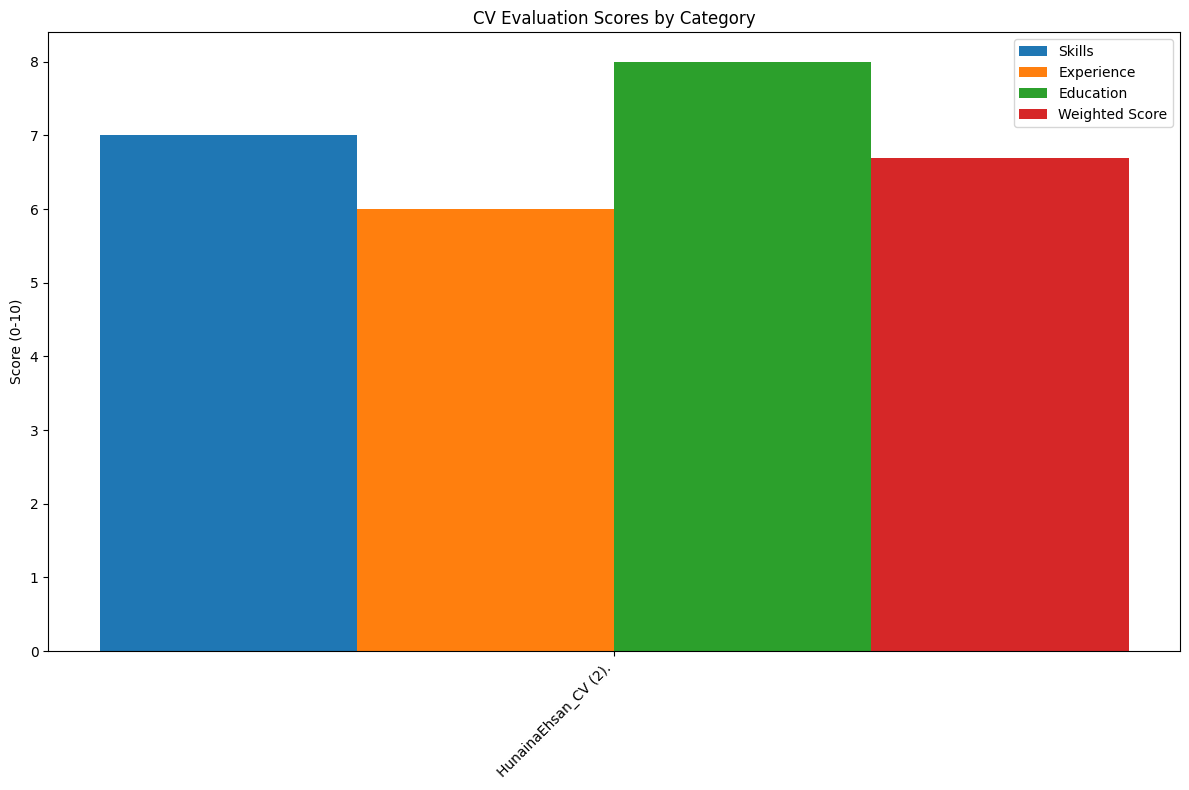


Detailed evaluation for top CV: HunainaEhsan_CV (2).pdf

=== Evaluation for HunainaEhsan_CV (2).pdf ===
Overall Score: 6.70/10

Skills:
Score: 7/10
Reasoning: The candidate has a strong background in Python and SQL, which are key requirements for the job. They also have experience with data engineering and databases. However, there is no mention of experience with data pipeline tools or cloud platforms such as AWS, Azure, or GCP. The candidate also does not demonstrate a strong understanding of data modeling and database design.
Strengths:
- Python
- SQL
- Data Engineering
- Databases
Gaps:
- Data pipeline tools
- Cloud platforms
- Data modeling and database design

Experience:
Score: 6/10
Reasoning: The candidate has worked on several projects involving data analysis and machine learning, which are relevant to the job. However, these projects do not seem to involve the design, development, or maintenance of scalable data pipelines, which is a key responsibility for the job. There is 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[{'filename': 'HunainaEhsan_CV (2).pdf',
  'score': 6.7,
  'evaluation': {'skills': {'score': 7,
    'reasoning': 'The candidate has a strong background in Python and SQL, which are key requirements for the job. They also have experience with data engineering and databases. However, there is no mention of experience with data pipeline tools or cloud platforms such as AWS, Azure, or GCP. The candidate also does not demonstrate a strong understanding of data modeling and database design.',
    'strengths': ['Python', 'SQL', 'Data Engineering', 'Databases'],
    'gaps': ['Data pipeline tools',
     'Cloud platforms',
     'Data modeling and database design']},
   'experience': {'score': 6,
    'reasoning': 'The candidate has worked on several projects involving data analysis and machine learning, which are relevant to the job. However, these projects do not seem to involve the design, development, or maintenance of scalable data pipelines, which is a key responsibility for the job. There 

In [12]:
# Run this cell to start the interactive CV ranking process
# This will guide you through all the steps:
# 1. Job description input
# 2. CV file upload
# 3. Configuration
# 4. Processing and evaluation
# 5. Results display
# 6. Export options

print("Ready to run CV Ranking System!")
print("To start, execute the function below:")
print("run_cv_ranking()")

# Uncomment this line to run the process
run_cv_ranking()